In [24]:
%matplotlib inline

In [25]:
import CoreFunctions_v6 as cf
import UtilityFunctions as uf
import numpy as np
# For theta computing.
from scipy.optimize import fmin_ncg
# For math processing.
import numpy as np
# For data plotting.
import matplotlib.pyplot as plt
# For notebook interaction (interactive dashboard). 
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
from IPython.display import clear_output

In [26]:
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets

# === EVENT HANDLER ===
def on_button_clicked(b):
    clear_output()
    global trainingData, testingData, feature
    # Read user inputs
    trainingTickerName = trainingTickerName_textbox.value
    trainingTickerStart = trainingTickerStart_textbox.value
    trainingTickerEnd = trainingTickerEnd_textbox.value

    testingTickerName = testingTickerName_textbox.value
    testingTickerStart = testingTickerStart_textbox.value
    testingTickerEnd = testingTickerEnd_textbox.value

    feature_input = feature_textbox.value  # e.g. "Adj. Close"
    # Normalize “Adj. Close” → “Adj Close” so it matches yfinance columns:
    feature = feature_input.replace(".", "").strip()

    # --- TRAINING DATA ACQUISITION ---
    # Fetch entire DataFrame via yfinance
    training_df = yf.download(trainingTickerName,
                              start=trainingTickerStart,
                              end=trainingTickerEnd,
                              progress=False)
    # Extract exactly the same pandas Series as before:
    trainingData = training_df[feature]

    # --- TESTING DATA ACQUISITION ---
    testing_df = yf.download(testingTickerName,
                             start=testingTickerStart,
                             end=testingTickerEnd,
                             progress=False)
    testingData = testing_df[feature]

    # --- PLOT EVERYTHING ---
    fig = plt.figure(figsize=(18, 10))

    ax = fig.add_subplot(2, 1, 1)
    ax.plot(trainingData)
    ax.set_title(f"Training: {trainingTickerName} {feature_input}",
                 fontsize=20, weight="bold")

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(testingData)
    ax2.set_title(f"Testing: {testingTickerName} {feature_input}",
                  fontsize=20, weight="bold")

    plt.tight_layout()
    plt.show()


# === CONTROLS ===
#  Training ticker name
trainingTickerName_textbox = widgets.Text(value="AAPL", description="")
trainingTickerName_textbox.layout.width = "10%"

#  Training start date
trainingTickerStart_textbox = widgets.Text(value="2008-01-01", description="")
trainingTickerStart_textbox.layout.width = "10%"

#  Training end date
trainingTickerEnd_textbox = widgets.Text(value="2014-12-31", description="")
trainingTickerEnd_textbox.layout.width = "10%"

#  Testing ticker name
testingTickerName_textbox = widgets.Text(value="AAPL", description="")
testingTickerName_textbox.layout.width = "10%"

#  Testing start date
testingTickerStart_textbox = widgets.Text(value="2015-01-01", description="")
testingTickerStart_textbox.layout.width = "10%"

#  Testing end date
testingTickerEnd_textbox = widgets.Text(value="2016-01-01", description="")
testingTickerEnd_textbox.layout.width = "10%"

#  Feature textbox (e.g. “Adj. Close”)
feature_textbox = widgets.Text(value="Close", description="")
feature_textbox.layout.width = "15%"

#  “Get data” button
button = widgets.Button(description="Get data")
button.on_click(on_button_clicked)

# === DISPLAY LAYOUT ===
display(widgets.HBox([
    widgets.Label("Enter ticker for training: "),
    trainingTickerName_textbox,
    widgets.Label("Start: "),
    trainingTickerStart_textbox,
    widgets.Label("End: "),
    trainingTickerEnd_textbox
]))

display(widgets.HBox([
    widgets.Label("Enter ticker for testing: "),
    testingTickerName_textbox,
    widgets.Label("Start: "),
    testingTickerStart_textbox,
    widgets.Label("End: "),
    testingTickerEnd_textbox
]))

display(widgets.HBox([
    button,
    widgets.Label("Use: "),
    feature_textbox
]))


interactive(children=(IntSlider(value=8, description='M', max=200), IntSlider(value=1000, description='T', max…

<function __main__.fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu, rho)>

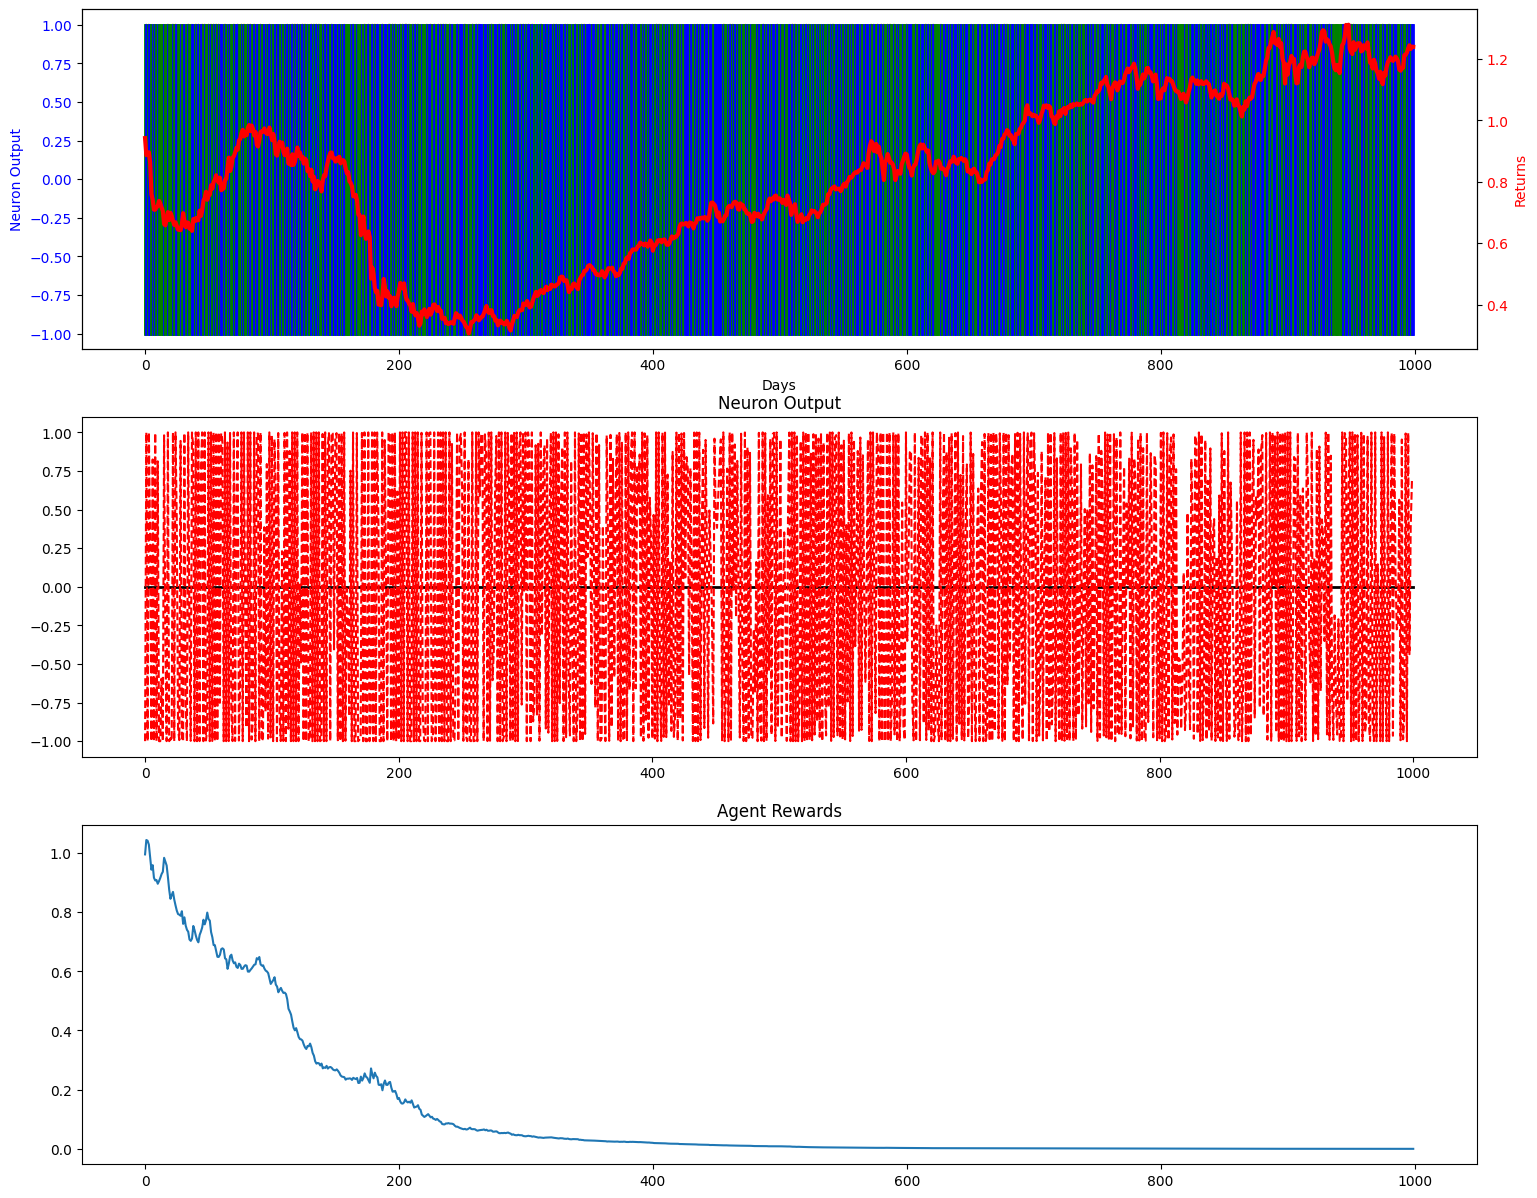

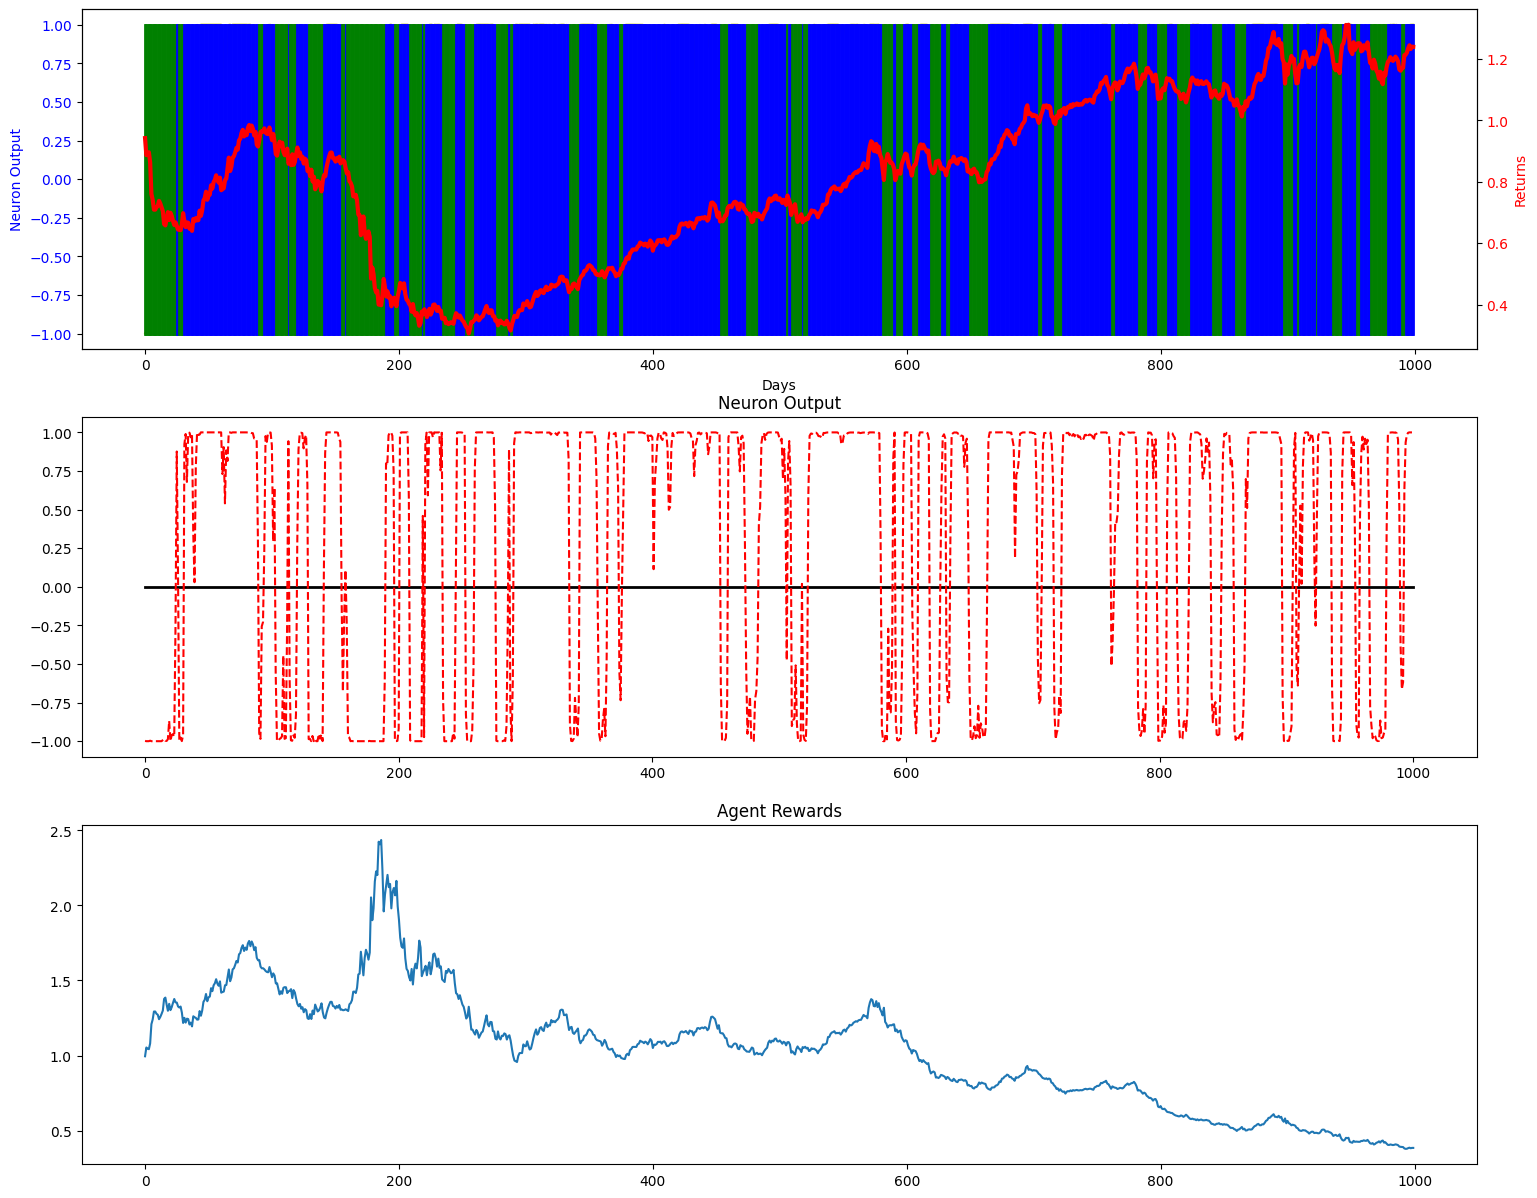

In [ ]:
###### VARIABLES INITIALIZATION ######
theta = []
###### END VARIABLES INITIALIZATION ######

###### EVENTS ######
def fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu, rho):
    global theta
    # Set the parameters
    startPos = M
    finishPos = startPos + T
    F = np.zeros(T + 1)
    dF = np.zeros(T + 1)
    
    # Generate the returns.
    X = uf.GetReturns(trainingData)
    Xn = uf.FeatureNormalize(X)
    
    # Initialize theta
    theta = np.ones(M+2)*initialTheta
    
    # Compute optimal theta value.
    #theta = fmin_ncg(cf.ObjectiveFunction, theta, cf.GradientFunctionM, args=(X, Xn, T, M, mu, transactionCosts, startPos, optimizationFunction), avextol=1e-8, maxiter=50)
    theta = cf.train(theta, X, Xn, T, M, mu, transactionCosts, startPos, rho, 500, optimizationFunction)
    
    # Compute the neuron output.
    F = cf.ComputeF(theta, Xn, T, M, startPos)
    
    # Compute the rewards
    rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
    # Compute the cumulative reward.
    rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
    for i in range(1, rewards.size):
        rewards[i] = rewards[i-1]*rewards[i]
    
    # Compute the cummulative returns.
    returns = X[startPos:finishPos] + 1
    for i in range(1, returns.size):
        returns[i] = returns[i-1]*returns[i]
    
    # Create figure for plotting.
    fig = plt.figure(figsize=(18,15))
    ## Plot rewards and policy decisions.
    ax1a = fig.add_subplot(3, 1, 1)
    ### Plot neuron output
    t = np.arange(0.0, 150.0, 1)
    ax1a.plot(F[1:], 'y')
    ax1a.set_xlabel('Days')
    ax1a.set_ylabel('Neuron Output', color='b')
    for tl in ax1a.get_yticklabels():
        tl.set_color('b')
    ### Plot the policy output.
    B = F[1:] > 0
    for i,b in enumerate(B):
        if b:
            plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
        else:
            plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
    ### Plot returns.
    ax1b = ax1a.twinx()
    ax1b.plot(returns, 'r-', linewidth=3)
    ax1b.set_ylabel('Returns', color='r')
    for tl in ax1b.get_yticklabels():
        tl.set_color('r')
        
    ### Plot Neuron output.
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("Neuron Output")
    ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
    ax2.plot(F[1:], color='r', linestyle='--')

    ### Plot agent rewards.
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("Agent Rewards")
    ax3.plot(rewards)
    
    print (cf.SharpeRatio(rewards[0:i]))
    
###### END EVENTS ######

###### CONTROLS ######
interact(fit, M=widgets.IntSlider(min=0,max=200,step=1,value=8), T=widgets.IntSlider(min=0,max=1000,step=1,value=1000),
        optimizationFunction = ["return","sharpeRatio"], initialTheta = 1, 
         transactionCosts = widgets.FloatSlider(min=0,max=0.1,step=0.001,value=0.005), mu = 1,
        rho = widgets.FloatSlider(min=0,max=1,step=0.1, value=0.01))
###### END CONTROLS ######

interactive(children=(IntSlider(value=10, description='M', max=200), IntSlider(value=100, description='T', max…

<function __main__.fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu)>

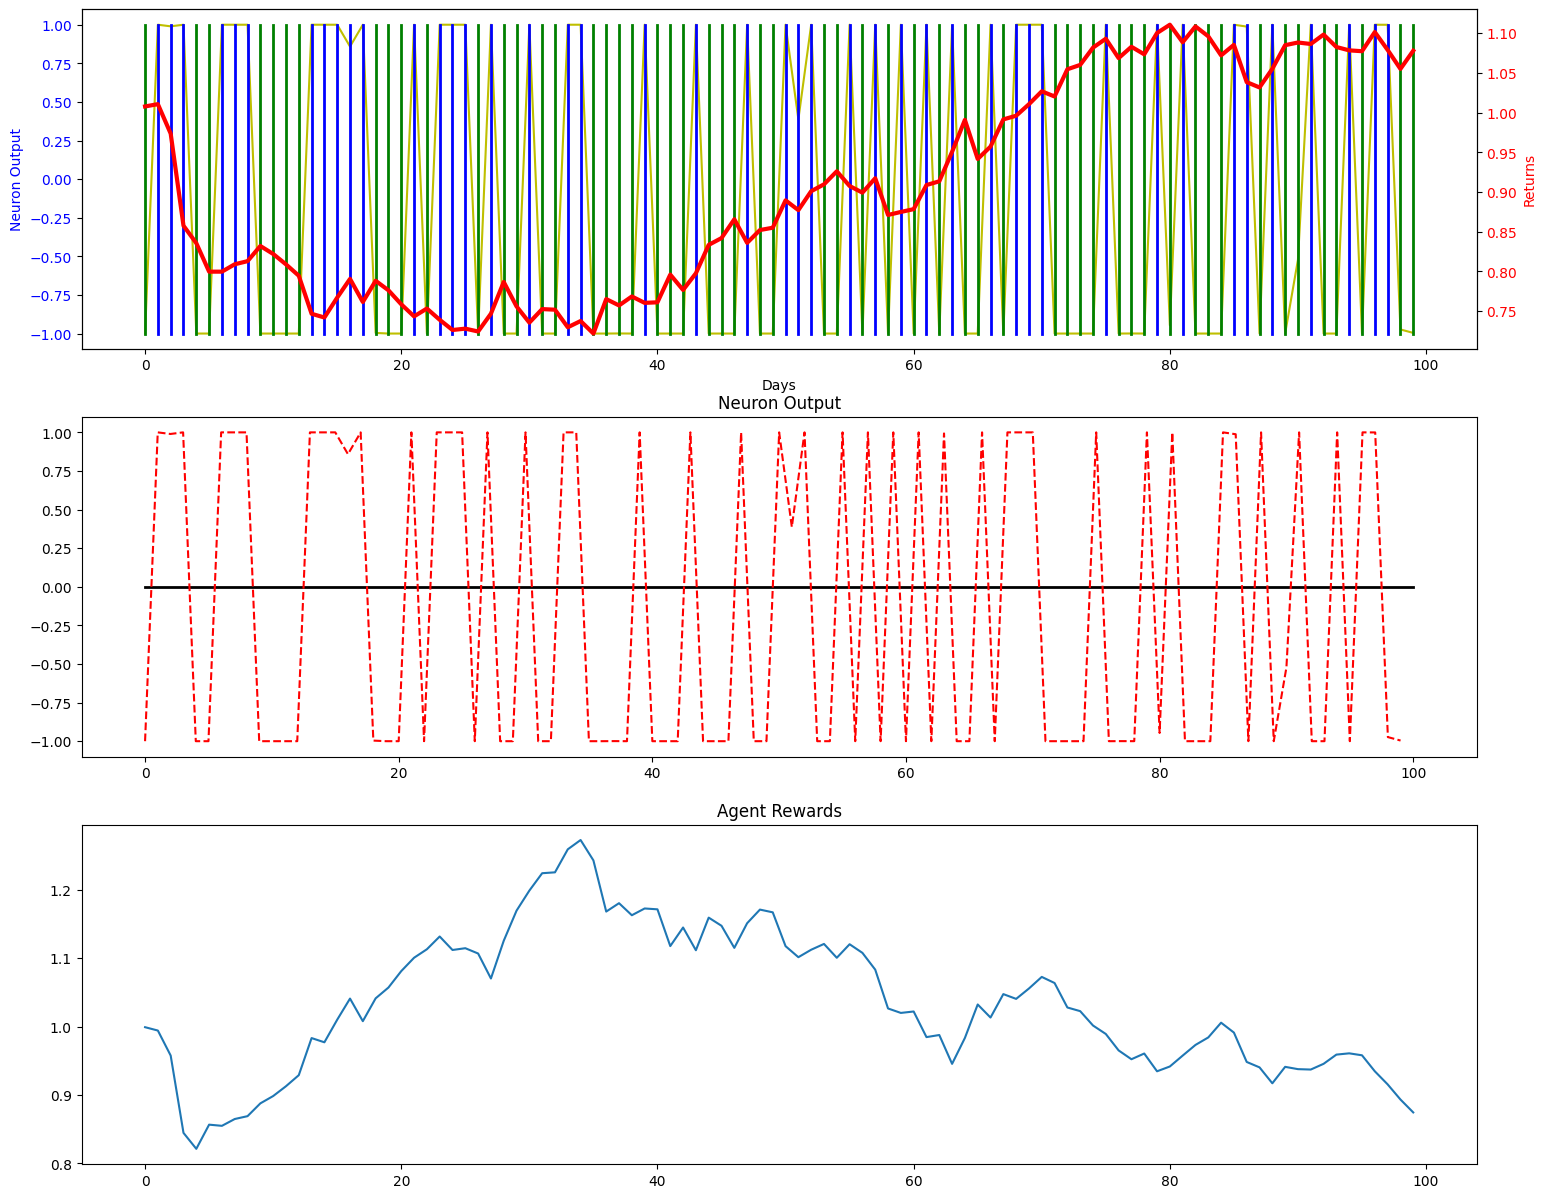

In [28]:
theta = []
###### EVENTS ######
def fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu):
    global theta
    # Set the parameters
    startPos = M
    finishPos = startPos + T
    F = np.zeros(T + 1)
    dF = np.zeros(T + 1)
    
    # Generate the returns.
    X = uf.GetReturns(trainingData)
    Xn = uf.FeatureNormalize(X)
    
    # Initialize theta
    theta = np.ones(M+2)*initialTheta
    
    # Compute optimal theta value.
    startPos += T
    I = 15

    print("Training ...")
    for i in range(1, I):
        print("On iteration: ", i)
        #theta = fmin_ncg(cf.ObjectiveFunction, theta, cf.GradientFunctionM, 
        #                  args=(X, Xn, T, M, mu, transactionCosts, startPos, optimizationFunction), 
        #                  avextol=1e-8, maxiter=50)

        theta = cf.train(theta, X, Xn, T, M, mu, transactionCosts, startPos, 1, 500, optimizationFunction)
        startPos += T
    print("Finished trainng.")
    startPos = M
    
    # Compute the neuron output.
    F = cf.ComputeF(theta, Xn, T, M, startPos)
    
    # Compute the rewards
    rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
    # Compute the cumulative reward.
    rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
    for i in range(1, rewards.size):
        rewards[i] = rewards[i-1]*rewards[i]
    
    # Get the cummulative returns.
    returns = X[startPos:finishPos] + 1
    for i in range(1, returns.size):
        returns[i] = returns[i-1]*returns[i]
    
    # Create figure for plotting.
    fig = plt.figure(figsize=(18,15))
    # Plot rewards and policy decisions.
    ax1a = fig.add_subplot(3, 1, 1)
    ## Plot neuron output
    t = np.arange(0.0, 150.0, 1)
    ax1a.plot(F[1:], 'y')
    ax1a.set_xlabel('Days')
    ax1a.set_ylabel('Neuron Output', color='b')
    for tl in ax1a.get_yticklabels():
        tl.set_color('b')
    ## Plot the policy output.
    B = F[1:] > 0
    for i,b in enumerate(B):
        if b:
            plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
        else:
            plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
    ## Plot returns.
    ax1b = ax1a.twinx()
    ax1b.plot(returns, 'r-', linewidth=3)
    ax1b.set_ylabel('Returns', color='r')
    for tl in ax1b.get_yticklabels():
        tl.set_color('r')
        
    # Plot Neuron output.
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("Neuron Output")
    ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
    ax2.plot(F[1:], color='r', linestyle='--')
    #ax2.ylim([-1,1])
    #ax2.xlim([0, finishPos])
    # Plot agent rewards.
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("Agent Rewards")
    ax3.plot(rewards)
    #ax3.xlim([0, finishPos])
    
###### END EVENTS ######

###### CONTROLS ######
interact(fit, M=widgets.IntSlider(min=0,max=200,step=1,value=10), T=widgets.IntSlider(min=0,max=1000,step=1,value=100),
        optimizationFunction = ["return","sharpeRatio"], initialTheta = 1, 
         transactionCosts = widgets.FloatSlider(min=0,max=0.1,step=0.001,value=0.001), mu = 1)
###### END CONTROLS ######

###### VARIABLES INITIALIZATION ######

###### END VARIABLES INITIALIZATION ######

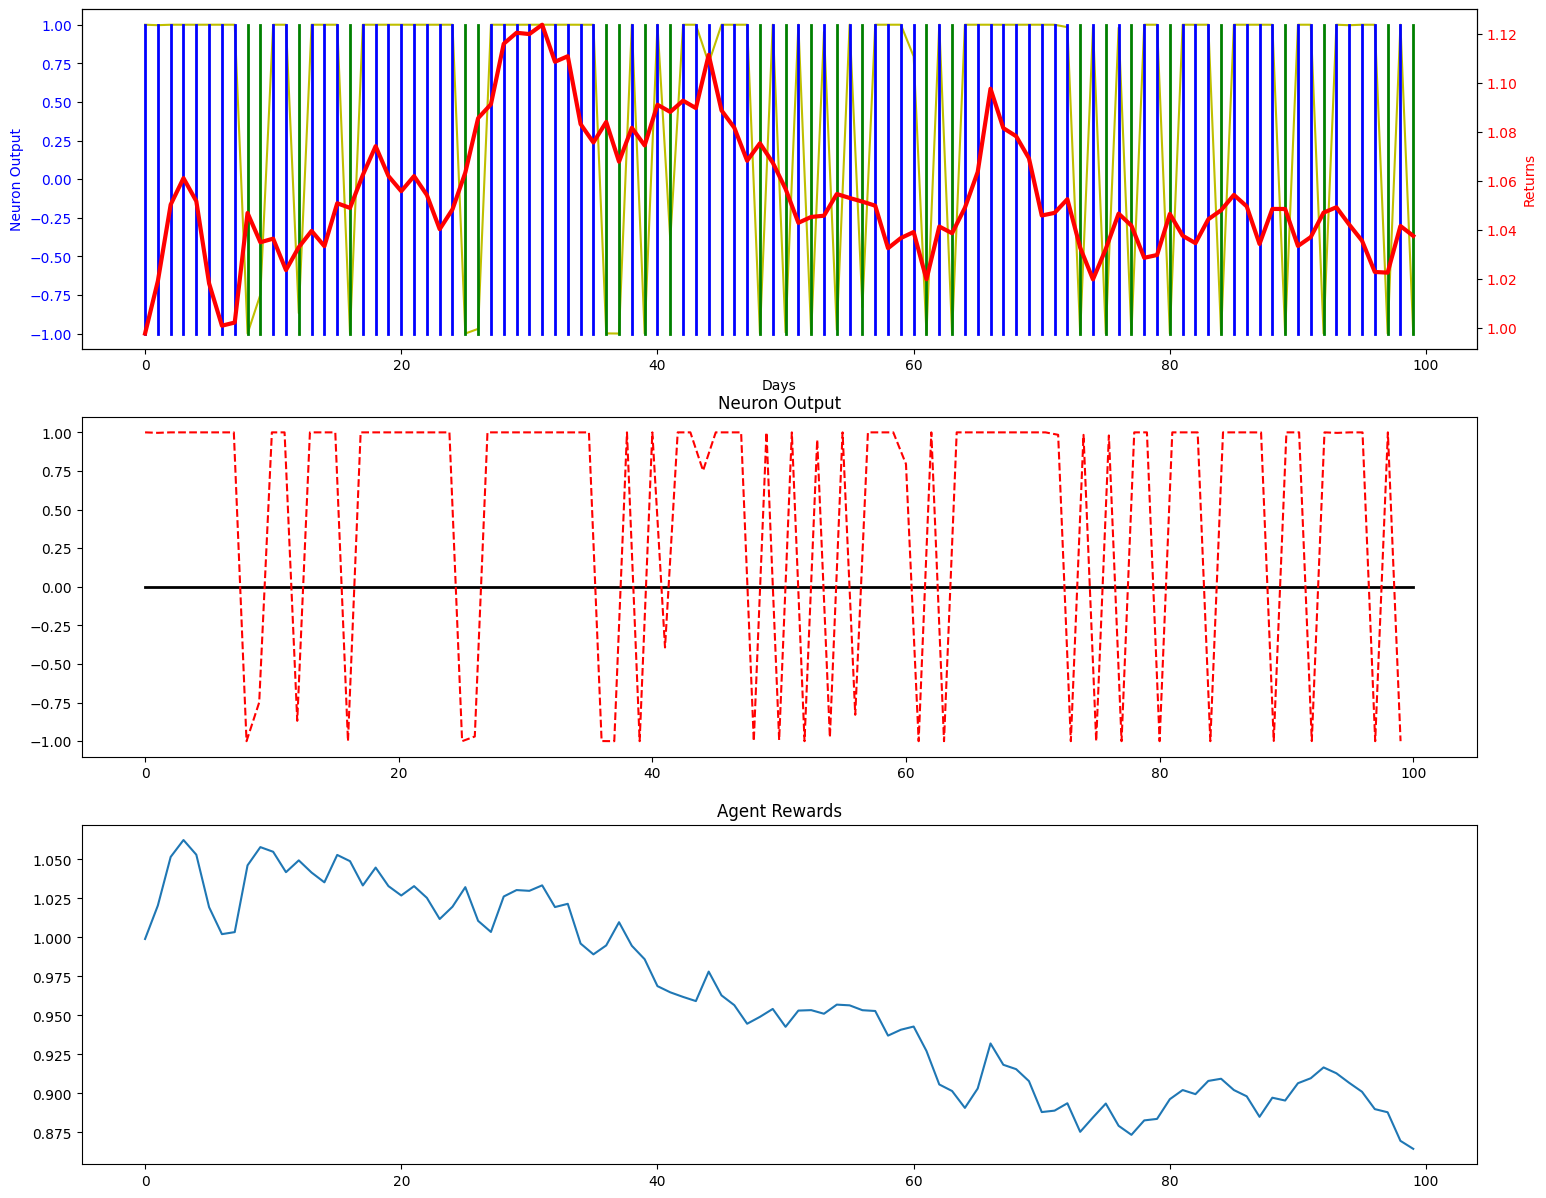

In [16]:
# Generate the returns.
X = uf.GetReturns(testingData)
Xn = uf.FeatureNormalize(X)

T = 100
M = 10
mu = 1
transactionCosts = 0.001
startPos = M
finishPos = startPos + T

# Compute the neuron output.
F = cf.ComputeF(theta, Xn, T, M, startPos)
    
# Compute the rewards
rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
# Compute the cumulative reward.
rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
for i in range(1, rewards.size):
    rewards[i] = rewards[i-1]*rewards[i]
    
# Get the cummulative returns.
returns = X[startPos:finishPos] + 1
for i in range(1, returns.size):
    returns[i] = returns[i-1]*returns[i]
    
# Create figure for plotting.
fig = plt.figure(figsize=(18,15))
# Plot rewards and policy decisions.
ax1a = fig.add_subplot(3, 1, 1)
## Plot neuron output
t = np.arange(0.0, 150.0, 1)
ax1a.plot(F[1:], 'y')
ax1a.set_xlabel('Days')
ax1a.set_ylabel('Neuron Output', color='b')
for tl in ax1a.get_yticklabels():
    tl.set_color('b')
## Plot the policy output.
B = F[1:] > 0
for i,b in enumerate(B):
    if b:
        plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
    else:
        plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
## Plot returns.
ax1b = ax1a.twinx()
ax1b.plot(returns, 'r-', linewidth=3)
ax1b.set_ylabel('Returns', color='r')
for tl in ax1b.get_yticklabels():
    tl.set_color('r')
        
# Plot Neuron output.
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title("Neuron Output")
ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
ax2.plot(F[1:], color='r', linestyle='--')
#ax2.ylim([-1,1])
#ax2.xlim([0, finishPos])
# Plot agent rewards.
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title("Agent Rewards")
ax3.plot(rewards)
#ax3.xlim([0, finishPos])